# Data Analysis 1 - Optimization on ArmV8

## Section 1: File Parsing

### Section 1.1: Reading Log Files

In [1]:
import os
import pandas as pd
import seaborn as sns
import sys 
sys.path.append('/home/zhouzikai/nn_ext_dataflows/data_analysis')
from scripts import build_dataframe
import re


BASELINE_DIR = '/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3'
EXTENDED_DIR = '/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log_ArmO3'

def parse_filename_bl(filename):
    pattern = r"([a-z]{2})_([0-9a-zA-Z]+)_baseline_(\d+)_hw_(\d+)_f_(\d+)_nf_(\d+)_s_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        return {
            'anchoring_stationary': match.group(1),
            'num_bits': num_bits,
            'vector_length': int(match.group(3)),
            'input_hw': int(match.group(4)),
            'filter_size': int(match.group(5)),
            'num_filters': int(match.group(6)),
            'stride': int(match.group(7)),
            'cpu_type': match.group(8),
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_data_size_df_bl(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_bl(filename)
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

def append_dataframe(df1, df2, join_keyword='filename'):
    '''
    add the 'size' column from df1 to df2, assuming their indices are the same (file path)
    '''
    merged_df = df2.join(df1)

    return merged_df



def parse_filename_ex(filename):
    pattern = r"vl(\d+)_([0-9a-zA-Z]+)_stride_(\d+)_fs_(\d+)_([a-z]{2})((?:_[a-zA-Z]+_\d+)+)_hw_(\d+)_nf_(\d+)_(\w+)CPU__stats\.txt"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        # Parsing and sorting auxiliary stationary and stats pairs
        aux_pairs_str = match.group(6)
        aux_pairs = re.findall(r"_([a-zA-Z]+)_(\d+)", aux_pairs_str)
        sorted_aux_pairs = sorted(aux_pairs, key=lambda x: x[0])

        aux_data = {}
        for i, (name, value) in enumerate(sorted_aux_pairs):
            if name not in aux_data:
                aux_data[f'aux_{name}'] = int(value)
            else:
                aux_data[f'aux_{name}_{i + 1}'] = int(value)

        return {
            'vector_length': int(match.group(1)),
            'num_bits': num_bits,
            'stride': int(match.group(3)),
            'filter_size': int(match.group(4)),
            'anchoring_stationary': match.group(5),
            'input_hw': int(match.group(7)),
            'num_filters': int(match.group(8)),
            'cpu_type': match.group(9),
            **aux_data
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}


def get_file_size(file_path):
    return os.path.getsize(file_path)


def get_data_size_df_ex(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_ex(filename)
        # if (get_file_size(f)) == 0:
        #     # print("found one empty")
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

# Read Baseline Directory
df_bl = get_data_size_df_bl(BASELINE_DIR)
bl_file_list=[]
for filename in os.listdir(BASELINE_DIR):
   f = os.path.join(BASELINE_DIR, filename)
   bl_file_list.append(f)
df_bl_files = build_dataframe(bl_file_list)
df_bl= append_dataframe(df_bl,df_bl_files)

# Read Extended Directory
df_ex = get_data_size_df_ex(EXTENDED_DIR)
ex_file_list=[]
for filename in os.listdir(EXTENDED_DIR):
   f = os.path.join(EXTENDED_DIR, filename)
   ex_file_list.append(f)
df_ex_files = build_dataframe(ex_file_list)
df_ex= append_dataframe(df_ex,df_ex_files)

In [2]:
df_bl

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,system.mem_ctrls.rdPerTurnAround::896-1023,size,anchoring_stationary,num_bits,vector_length,input_hw,filter_size,num_filters,stride,cpu_type
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,5.664908e+10,5.664908e+10,1.000000e+12,280.72,201802520.0,681144.0,42124919.0,42396496.0,150063.0,...,NaN,172399,ws,1,128,112,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,4.103061e+09,4.103061e+09,1.000000e+12,53.96,76038771.0,681144.0,21393754.0,21665456.0,396472.0,...,NaN,172141,os,1,128,56,4,16,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,1.398118e+10,1.398118e+10,1.000000e+12,92.45,151236364.0,681140.0,18554340.0,21032824.0,200705.0,...,NaN,172265,ws,1,512,56,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,4.713684e+10,4.713684e+10,1.000000e+12,242.88,194071399.0,681140.0,37855927.0,38127504.0,155860.0,...,NaN,172137,ws,1,128,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,1.415693e+10,1.415693e+10,1.000000e+12,147.49,95987469.0,681144.0,43321281.0,55780535.0,293729.0,...,NaN,171877,os,8,512,112,5,16,2,ArmO3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,2.511420e+10,2.511420e+10,1.000000e+12,173.58,144682786.0,681144.0,50598563.0,50870169.0,291498.0,...,NaN,172394,is,1,128,56,3,64,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,1.388558e+09,1.388558e+09,1.000000e+12,15.11,91923314.0,680116.0,4460928.0,4732103.0,295313.0,...,NaN,171734,os,8,128,56,3,16,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,5.776026e+10,5.776026e+10,1.000000e+12,331.96,174000023.0,681144.0,61456501.0,69615596.0,185135.0,...,NaN,172013,ws,1,512,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,1.793547e+09,1.793547e+09,1.000000e+12,19.46,92150946.0,681144.0,5166835.0,6405958.0,265466.0,...,NaN,171874,os,8,512,56,4,8,2,ArmO3


In [3]:
len(df_bl)

812

In [4]:
len(df_ex)

2080

### Section 2.2: Filtering to Useful Columns Only

In [5]:
COL_FILTER = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters"]

REF_COLS = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters","system.cpu.dcache.demandMissRate::cpu.data","system.cpu.dcache.demandAvgMissLatency::total","system.cpu.dcache.writebacks::total","system.mem_ctrls.dram.numReads::cpu.data","system.mem_ctrls.dram.numWrites::total"]

df_bl = df_bl[COL_FILTER]
df_ex = df_ex[COL_FILTER]

In [6]:
df_ex = df_ex.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"]).min()

In [7]:
df_bl

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,42124919.0,42396496.0,128,1,2,3,ws,112,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,21393754.0,21665456.0,128,1,1,4,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,18554340.0,21032824.0,512,1,2,3,ws,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,37855927.0,38127504.0,128,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,43321281.0,55780535.0,512,8,2,5,os,112,16
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,50598563.0,50870169.0,128,1,1,3,is,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,4460928.0,4732103.0,128,8,2,3,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,61456501.0,69615596.0,512,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,5166835.0,6405958.0,512,8,2,4,os,56,8


In [8]:
df_ex

simSeconds   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       1           is                      0.000088  \
                                                               os                      0.000070   
                                                               ws                      0.000054   
                                                   2           is                      0.000106   
                                                               os                      0.000090   
...                                                                                         ...   
512           8        2      5           112      32          os                      0.024727   
                                                               ws                      0.158371   
                                                   64          is                      0.076971   
                                                               os                      0.050278   
                                                               ws                      0.318073   

                                                                                        simInsts   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                
128           1        1      3           56       1           is                      1775356.0  \
                                                               os                      1832004.0   
                                                               ws                      1772460.0   
                                                   2           is                      1884023.0   
                                                               os                      2006379.0   
...                                                                                          ...   
512           8        2      5           112      32          os                     46208430.0   
                                                               ws                     58990644.0   
                                                   64          is                    349557188.0   
                                                               os                     90759558.0   
                                                               ws                    116323980.0   

                                                                                          simOps  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       1           is                      2046179.0  
                                                               os                      2101109.0  
                                                               ws                      2041586.0  
                                                   2           is                      2154854.0  
                                                               os                      2275492.0  
...                                                                                          ...  
512           8        2      5           112      32          os                     81436901.0  
                                                               ws                     71564876.0  
                                                   64          is                    420533721.0  
                                                               os                    160947422.0  
                                                               ws                    141203365.0  

[1188 rows x 3 columns]

### Section 2.3: Merging baseline and optimized dataframes

In [9]:
df_ex = df_ex.rename(columns={"simSeconds":"simSeconds_opt","simInsts":"simInsts_opt","simOps":"simOps_opt"})
df_merged = pd.merge(df_ex,df_bl,how='left',\
                    left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"],\
                    right_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"])

In [10]:
NUM_FILTER_LOWER = 8
NUM_FILTER_UPPER = 32
VEC_LEN_LIST = [128,256,512]

In [11]:
df_merged

,vector_length,num_bits,stride,filter_size,input_hw,num_filters,anchoring_stationary,simSeconds_opt,simInsts_opt,simOps_opt,simSeconds,simInsts,simOps
0,128,1,1,3,56,1,is,0.000088,1775356.0,2046179.0,NaN,NaN,NaN
1,128,1,1,3,56,1,os,0.000070,1832004.0,2101109.0,NaN,NaN,NaN
2,128,1,1,3,56,1,ws,0.000054,1772460.0,2041586.0,NaN,NaN,NaN
3,128,1,1,3,56,2,is,0.000106,1884023.0,2154854.0,NaN,NaN,NaN
4,128,1,1,3,56,2,os,0.000090,2006379.0,2275492.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,512,8,2,5,112,32,os,0.024727,46208430.0,81436901.0,0.027347,84974677.0,109622091.0
1184,512,8,2,5,112,32,ws,0.158371,58990644.0,71564876.0,0.084633,82078547.0,94541802.0
1185,512,8,2,5,112,64,is,0.076971,349557188.0,420533721.0,NaN,NaN,NaN
1186,512,8,2,5,112,64,os,0.050278,90759558.0,160947422.0,0.053818,168281642.0,217305409.0


In [12]:
df_merged = df_merged[(df_merged["num_filters"]>= NUM_FILTER_LOWER) &(df_merged["num_filters"]<= NUM_FILTER_UPPER)& (df_merged["vector_length"].isin(VEC_LEN_LIST)) & (df_merged["stride"]==1)]

<Axes: xlabel='simSeconds'>

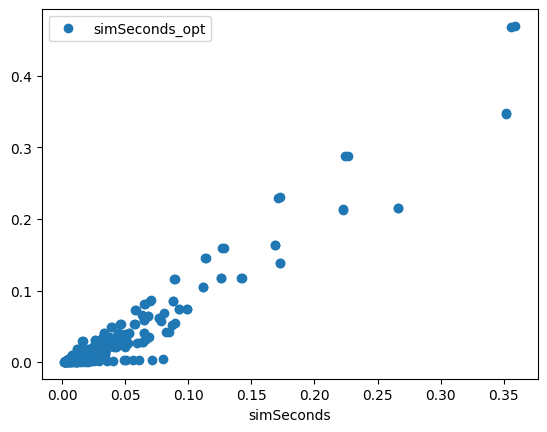

In [13]:
df_merged.plot(x="simSeconds",y="simSeconds_opt",style=['o','rx'])

## Section 2: Calculating Improvments

In [14]:
df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]

/tmp/ipykernel_401484/1120125696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]


(array([ 0.,  0.,  5., 35., 47., 31., 33., 37., 40., 22., 14.,  8.,  0.,
         0.,  1.,  5.,  0.,  0.,  0.,  2.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

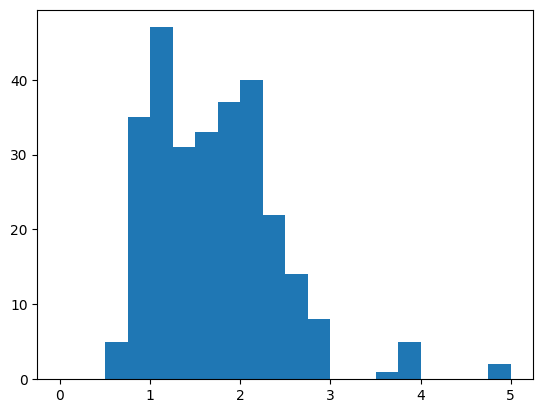

In [15]:
import matplotlib.pyplot as plt

plt.hist(df_merged['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  8.,  7., 23., 16.,  9.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

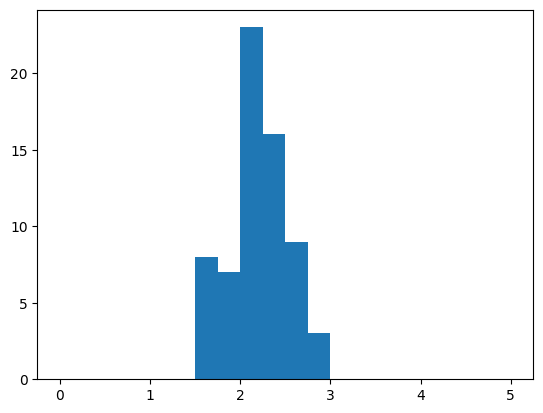

In [32]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='is']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  4., 11., 17., 20., 27., 17.,  4.,  4.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

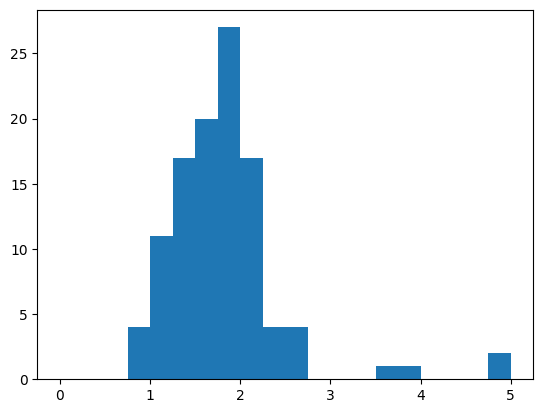

In [17]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='os']['improvement'], range=[0, 5],bins=20)

In [18]:
df_merged['improvement'].mean()

4.108770000834351

In [19]:
df_merged['improvement'].median()

1.7932540127990122

In [28]:
len(df_merged["vector_length"]==128)

324

In [38]:
df_merged[df_merged["vector_length"]==128].to_excel("128improve.xlsx")

In [29]:
len(df_merged["vector_length"]==256)

324

In [30]:
len(df_merged["vector_length"]==512)

324

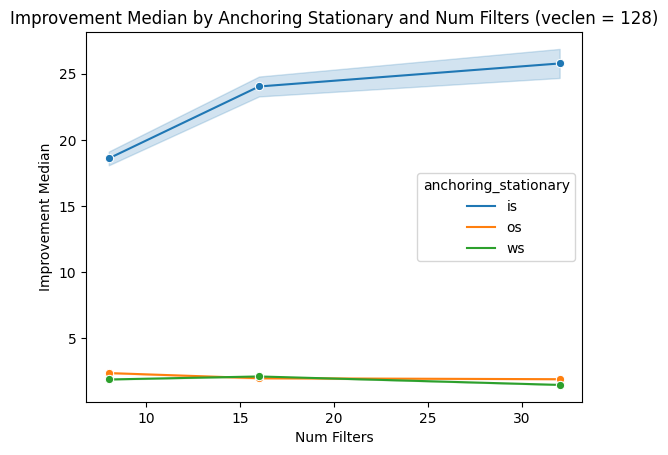

In [36]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits"])["improvement"].median().reset_index()
sns.lineplot(data=grouped_df[(grouped_df["vector_length"]==128)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 128)'
)
plt.show()

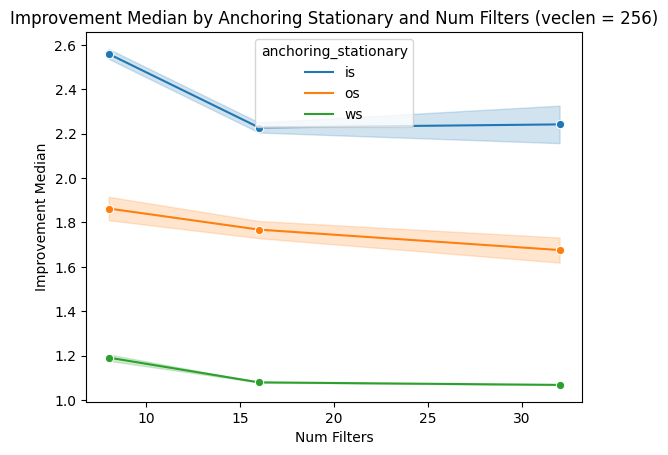

In [21]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==256], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 256)'
)
plt.show()

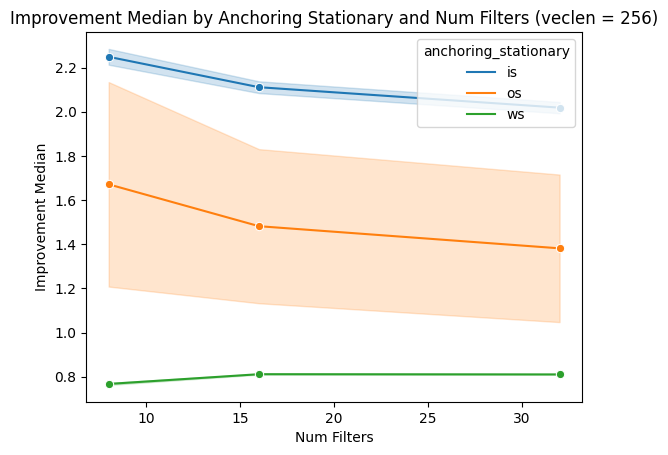

In [22]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==512], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 256)'
)
plt.show()